In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from ionization import ionization
from lens import profile
from lens import design
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam.elements import optic
from beam import interactions
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
plt.style.use('notes')
%load_ext autoreload
%autoreload 2

path = '/mnt/md0/Data/rariniello/Experimental/1inAxicon/Test/'
lam = 0.796

In [2]:
# Create a laser beam, pulse and axicon lens
Nx = 2**13
X = 60e3
tau = 80
pulseParams = {'Nx' : Nx,
               'Ny' : Nx,
               'Nt' : 2**6,
               'X' : X,
               'Y' : X,
               'T' : 3*tau,
               'lam' : lam,
               'path' : path,
               'name' : 'FlattopBeam',
               'threads' : 20,
               'cyl' : True,
               'tau' : tau,
               'load' : False}

beam = laserbeam.Laser(pulseParams)

alpha = 0.5
n = 1.458
beta = np.degrees(np.arcsin(n*np.sin(np.radians(alpha)))) - alpha
print('Axicon deflection angle : %0.3f deg' % beta)
lensParams = {'Nx' : Nx,
              'Ny' : Nx,
              'X' : X,
              'Y' : X,
              'path' : path,
              'name' : 'Axicon',
              'lam' : lam,
              'beta' : beta,
              'load' : False}
axicon = optic.AxiconLens(lensParams)

apertureParams = {'Nx' : pulseParams['Nx'],
                  'Ny' : pulseParams['Ny'],
                  'X' : pulseParams['X'],
                  'Y' : pulseParams['Y'],
                  'path' : path,
                  'name' : 'Aperturen',
                  'lam' : lam,
                  'r' : 25.4e3/2,
                  'load' : False}

aperture = optic.Aperture(apertureParams)

#%
# Create a super gaussian intensity profile and pass it through a lens.
w0 = 20e3
E0 = 1.2#1
n = 8
x2 = np.reshape(beam.x, (beam.Nx, 1))**2
y2 = np.reshape(beam.y, (1, beam.Ny))**2
r = np.sqrt(x2 + y2)
e = E0 * np.exp(-(r/w0)**n)

beam.initialize_field(e)
#beam.plot_current_intensity()
print('Power:', beam.total_cyl_power(beam.x[int(beam.Nx/2):],
                                         beam.intensity_from_field(beam.e[int(beam.Nx/2):, int(beam.Ny/2)])))
interactions.beam_intensity(beam, aperture)

interactions.beam_phase(beam, axicon)
#interactions.beam_intensity(beam, aperture)
#beam.plot_current_intensity()
r = beam.x[int(Nx/2):]
E = beam.e[int(Nx/2):, int(Nx/2)]
del beam
#%
# Create the gas density the laser is going into
ne0 = 1 #*1e17
z = np.linspace(0, 4e6, 10000)
sim_start = 50e4
n0= np.zeros(z.shape)+ne0

n= interp1d(z, n0)
#sim_start, n_plot, n = profile.lithium_oven_profile(z, 40e4+sim_start, ne0)
sim_length = 280e4#3e6 #80e4
#np.save(path+'sim_size.npy', [sim_start, sim_length])

Axicon deflection angle : 0.229 deg
Power: 1.8305246697201845


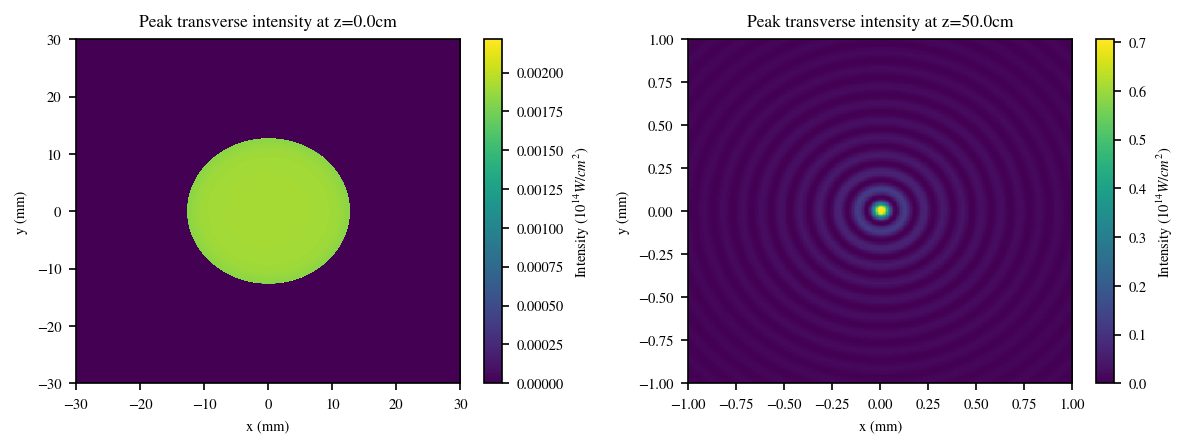

In [3]:
X = 60e3
Nx = 2**13
beam0, pulseParams = design.propagate_to_start(r, E, sim_start, X, Nx, path, lam, tau, 20, [-1, 1])

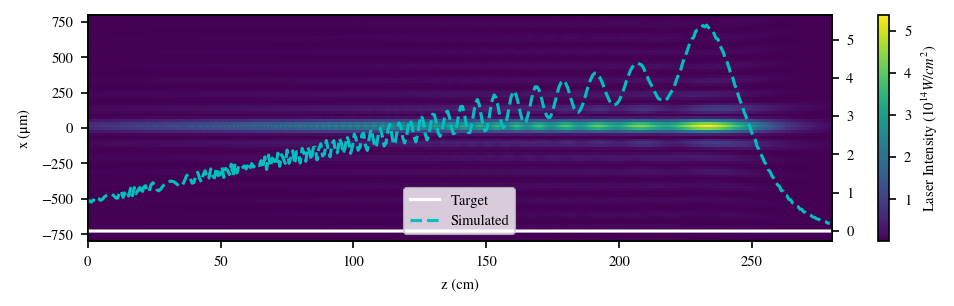

In [5]:
Nx = 2**10
Nz = 400
X =20e3
design.domain_test(X, Nx, sim_length, Nz, beam0, pulseParams, z, np.zeros(len(z)), sim_start, [-800, 800]);

In [6]:
Nx =2**10
Nz = 100
#Nx = 2**12
#Nz = 300
ext = [0, sim_length/1e4, -X/2, X/2]
#plt.style.use('presentation')
pulse, I, ne = design.plasma_refraction(X, Nx, sim_length, Nz, beam0, pulseParams, ionization.Ar, n, sim_start, 1, ne0)

Initial pulse energy 74.16mJ
Final pulse energy 73.12mJ


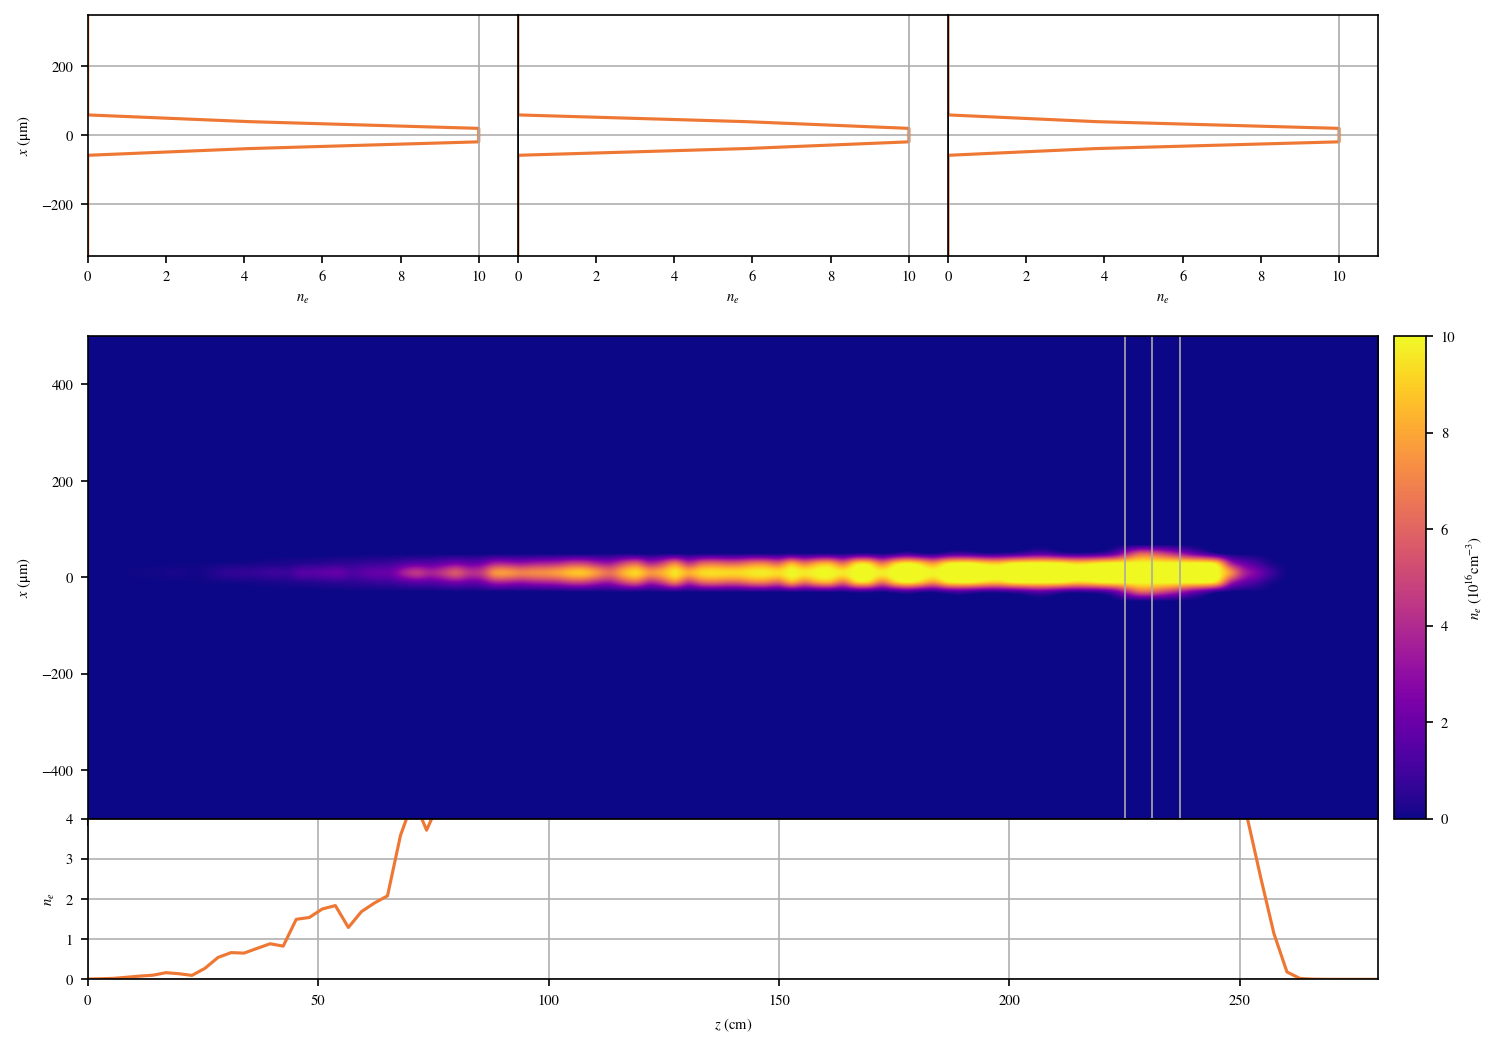

In [7]:
design.plot_plasma_density(pulse, ne, ne0, ext, lines=[225, 231, 237])

In [ ]:
plt.pcolormesh(ne)
#%%
plt.plot(ne[82, :])
#%%
np.save('Lineout', ne[82, :])
#%%
np.save('ne', ne)
#%%
np.save('Grid', ext)